# Shallow Neural Networks [\[shallow-neural-networks\]](https://www.geeksforgeeks.org/deep-learning/shallow-neural-networks/)<br>

### COMPONENTS
- _input layer_ --> network receives input data. each neuron is a feature of the input dataset
- _hidden layer_ (ONLY ONE) --> neurons apply a set of weights to the inputs and pass them through the activation function to introduce non-linearity to the process.
- _output layer_ --> network produces output of the network. 
### FUNCTIONALITIES
- _weighted sum_ --> each neuron in the hidden layer calculates weighted sums of the inputs
- _activation function_ --> to introduce non linearity
- _output generation_ --> output layer integrates signals from hidden layer through another set of weights to produce final output
### INVOLVED IN THE TRAINING
- _forward propagation_ --> calculating the output for a given input by passing it through the layers of the network
- _loss calculation_ --> determining how far the network's output is from the actual desired output using a loss function
- _backpropagation_ --> calculating the gradient of the loss function with respect to each weight in the network, which informs how the weights should be adjusted to minimize the loss
- _weight update_ --> adjusting the weights using an optimization algorithm like gradient descent

**! LOCAL MODEL** = una rete per ogni time serie (per ora faccio questo) <br>
**GLOBAL MODEL** = una rete unica: se ho serie simili (PIL di 10 paesi diversi) posso mettere dati insieme e rete impara modello generale di crescita economica

## MULTI LAYER PERCEPTRON (MLP) [\[MLP-machinelearningmastery\]](https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/)

1. [import + upload + preprocessing](#upload)
2. [data augmentation](#data-augmentation)
3. [scaling](#scaling)
4. [sliding window](#sliding-window)
5. [definition and training of NN](#training)
6. [future predictions with recursive prediction](#predictions) = per predirre 2027 uso reale2022-reale2023-reale2024-_predizione2025_

## Import + upload + preprocessing <a class="anchor" id="upload"></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

# plot styles
colors = ['#1f77b4', '#ff7f0e', '#d62728',  '#2ca02c']

UNUSABLE = [
    "Rural population living in areas where elevation is below 5 meters (% of total population)",
    "Access to electricity, rural (% of rural population)",
    "Surface area (sq. km)",
    "Rural land area (sq. km)",
    "Land area (sq. km)",
    "Average precipitation in depth (mm per year)",
    "Agricultural irrigated land (% of total agricultural land)",
    "Rural land area where elevation is below 5 meters (% of total land area)",
    "Rural land area where elevation is below 5 meters (sq. km)"
]

In [2]:
df = pd.read_excel('./italy_values_dataset.xlsx')

In [3]:
target = (
    df[df["Indicator Name"] == 'Rural population (% of total population)']
    .melt(id_vars=["Indicator Name"], var_name="Year", value_name="Value")
    .assign(Year=lambda d: d["Year"].astype(int))
    .dropna(subset=["Value"])
    [["Year", "Value"]]
    .reset_index(drop=True)
)

## Data augmentation <a class="anchor" id="data-augmentation"> 

array([1960., 1961., 1962., 1963., 1964., 1965., 1966., 1967., 1968.,
       1969., 1970., 1971., 1972., 1973., 1974., 1975., 1976., 1977.,
       1978., 1979., 1980., 1981., 1982., 1983., 1984., 1985., 1986.,
       1987., 1988., 1989., 1990., 1991., 1992., 1993., 1994., 1995.,
       1996., 1997., 1998., 1999., 2000., 2001., 2002., 2003., 2004.,
       2005., 2006., 2007., 2008., 2009., 2010., 2011.])

array([2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019., 2020.,
       2021., 2022., 2023., 2024.])

array([40.639, 40.144, 39.645, 39.147, 38.65 , 38.157, 37.666, 37.178,
       36.691, 36.208, 35.728, 35.25 , 34.961, 34.759, 34.558, 34.357,
       34.156, 33.956, 33.757, 33.558, 33.36 , 33.163, 33.114, 33.134,
       33.154, 33.174, 33.194, 33.214, 33.234, 33.254, 33.274, 33.294,
       33.258, 33.198, 33.138, 33.078, 33.018, 32.958, 32.898, 32.838,
       32.778, 32.718, 32.618, 32.499, 32.38 , 32.262, 32.144, 32.026,
       31.908, 31.791, 31.673, 31.556])

array([31.316, 31.021, 30.728, 30.435, 30.145, 29.856, 29.562, 29.264,
       28.961, 28.654, 28.343, 28.027, 27.708])

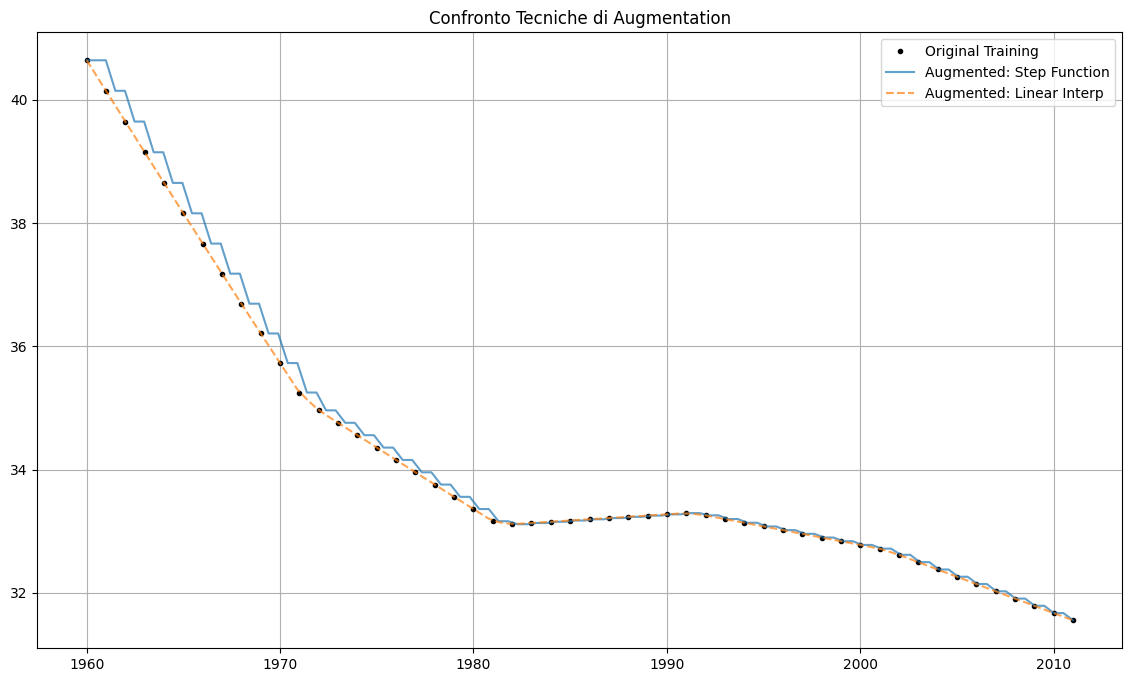

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
np.random.seed(42)
# usa gli anni come asse x e i valori target come y
x = target['Year'].to_numpy().astype(float)
y = target['Value'].to_numpy().astype(float)

train_size = int(0.8 * len(x))
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

def augment_step_function(x_in, y_in, scale_factor=2):
    """
    Aumenta la risoluzione usando una Step Function (Zero-order hold).
    Scale factor 2 raddoppia i punti.
    """
    f = interp1d(x_in, y_in, kind='previous', fill_value="extrapolate")
    # Creiamo nuovi punti x più fitti
    x_new = np.linspace(x_in.min(), x_in.max(), len(x_in) * scale_factor)
    y_new = f(x_new)
    return x_new, y_new

def augment_linear_interp(x_in, y_in, scale_factor=2):
    """
    Aumenta la risoluzione usando Interpolazione Lineare.
    """
    f = interp1d(x_in, y_in, kind='linear', fill_value="extrapolate")
    x_new = np.linspace(x_in.min(), x_in.max(), len(x_in) * scale_factor)
    y_new = f(x_new)
    return x_new, y_new

def augment_gaussian_noise(y_in, noise_level=0.05):
    """
    Aggiunge rumore gaussiano ai dati esistenti.
    Non cambia il numero di punti, ma crea una variazione dell'ampiezza.
    """
    noise = np.random.normal(0, noise_level, y_in.shape)
    return y_in + noise

x_step, y_step = augment_step_function(x_train, y_train, scale_factor=2)

x_lin, y_lin = augment_linear_interp(x_train, y_train, scale_factor=2)

augmented_noise_datasets = [augment_gaussian_noise(y_train) for _ in range(3)]

display(x_train, x_test)
display(y_train, y_test)
plt.figure(figsize=(14,8))
plt.plot(x_train, y_train, '.', label=f'Original Training', color='black')
plt.plot(x_step, y_step, '-', label='Augmented: Step Function', alpha=0.7)
plt.plot(x_lin, y_lin, '--', label='Augmented: Linear Interp', alpha=0.7)
plt.title("Confronto Tecniche di Augmentation")
plt.legend()
plt.grid(True)
plt.show()

[Time Series Data Augmentation for Deep Learning: A Survey](https://arxiv.org/abs/2002.12478)

Noise injection is a method by injecting small amount
of noise/outlier into time series without changing the corresponding labels. This includes injecting Gaussian noise,
spike, step-like trend, and slope-like trend, etc.

[Time series forecasting using a hybrid ARIMA and neural network model](https://www.sciencedirect.com/science/article/pii/S0925231201007020)
Although ARIMA models are quite flexible in that they can represent several different types of time series, i.e., pure autoregressive (AR), pure moving average (MA) and combined AR and MA (ARMA) series, their major limitation is the pre-assumed linear form of the model. That is, a linear correlation structure is assumed among the time series values and therefore, no nonlinear patterns can be captured by the ARIMA model. 

Many empirical studies including several large-scale forecasting competitions suggest that by combining several different models, forecasting accuracy can often be improved over the individual model without the need to find the “true” or “best” model

In [ ]:
def add_gaussian_noise(time_series, mean=0.0, stddev=1.0):
    """
    Adds Gaussian noise to a time series.

    Options:
    time_series (array-like): A time series to which noise is added.
    mean (float): The average value of the noise. Default is 0.0.
    stddev (float): Standard deviation of noise. Default is 1.0.

    Returns:
    noisy_series (np.array): Time series with added noise.
    """
    # Gaussian noise generation
    noise = np.random.normal(mean, stddev, len(time_series))

    # Adding noise to the original time series
    noisy_series = time_series + noise

    return noisy_series

augmented_time_series_data = add_gaussian_noise(time_series_data, mean=0.0, stddev=0.05)

In [4]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
values = target['Value'].values.astype('float32')
values = values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_values = scaler.fit_transform(values)

n_steps = 3
X, y = split_sequence(scaled_values, n_steps)
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

model = Sequential()
model.add(Dense(24, activation='relu', input_dim=n_steps))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=500, verbose=1) 

last_input = scaled_values[-n_steps:] 
last_input = last_input.reshape((1, n_steps))
yhat_scaled = model.predict(last_input, verbose=0)
yhat = scaler.inverse_transform(yhat_scaled)

print(f"Input (ultimi {n_steps} anni scalati): {scaler.inverse_transform(last_input)}")
print(f"Predizione per l'anno prossimo (valore reale): {yhat[0][0]}")

c:\Users\oldan\Desktop\RuralDevelopment\progetto-tirocinio\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.2631
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2365
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2120
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1903
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1680
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.1490
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1310
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1139
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0990
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0854
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0735
Epoch 12/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0622
Epoch 13/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0528
Epoch 14/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0444
Epoch 15/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0369
Epoch 16/500
2/2 ━━

RADIAL BASIS FUNCTION (RBF) NETWORK

EXTREME LEARNING MACHINE (ELM)